In [2]:
import pandas as pd
import lightgbm as lgb
from datetime import datetime, timedelta
import tqdm
import numpy as np
from sklearn.metrics import f1_score
np.random.seed(4242)

In [3]:
#def parse_dt(s):
#    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

#df = pd.read_csv('dataset/dataset.csv',  encoding='cp1251')
#df = df.fillna(0)
#df['date'] = df['date'].apply(parse_dt)

df = pd.read_csv(
    '../../data/dataset_utf.csv',
    parse_dates=['date']
)

In [4]:
stops = pd.read_csv('../../data/stops.csv', parse_dates=['date'])

In [7]:
def make_range(df, stop_dt):
    return (df['date'] >= (stop_dt - timedelta(hours=1))) & (df['date'] < stop_dt)

df_no_stops = df.copy()
for stop_dt in tqdm.tqdm(stops['date']):
    df_no_stops = df_no_stops[~make_range(df_no_stops, stop_dt)]

100%|██████████| 66/66 [00:42<00:00,  1.56it/s]


In [8]:
def make_features(df):
    vecs = []
    columns = df.columns[df.columns != 'date']
    for period in [1, 5, 10, 20, 30, 100, 360]:
        mean = df[-period:][columns].mean(axis=0).values
        min = df[-period:][columns].min(axis=0).values
        max = df[-period:][columns].max(axis=0).values
        std = df[-period:][columns].std(axis=0).values
        median = df[-period:][columns].median(axis=0).values
        feats = np.hstack([mean, min, max, std, median])
        vecs.append(feats)
    
    return np.hstack(vecs)

def make_false(df_no_stops):
    random_work = np.random.choice(df_no_stops.shape[0], 10000)
    xs = []
    ys = []
    
    for work in tqdm.tqdm(random_work):
        rng = df_no_stops[make_range(df_no_stops, df_no_stops.iloc[work]['date'])]
        feature_vector = make_features(rng)
        xs.append(feature_vector)
        ys.append(0)
    
    return np.array(xs), np.array(ys)

X_false, y_false = make_false(df_no_stops)

100%|██████████| 10000/10000 [13:50<00:00, 12.04it/s]


In [10]:
def make_true(df_with_stops, df_y):
    xs = []
    ys = []    
    for stop_dt in df_y['date'][:-1]: # the last date is out of df range
        rng = df_with_stops[make_range(df_with_stops, stop_dt)]
        feature_vector = make_features(rng)
        xs.append(feature_vector)
        ys.append(1)
    return np.array(xs), np.array(ys)

X_true, y_true = make_true(df, stops)

In [11]:
X = np.vstack([X_false, X_true])
y = np.hstack([y_false, y_true]).T

In [12]:
def make_train_val(X, y):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=3)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        yield X_train, y_train, X_test, y_test

In [13]:
f_scores = []
for X_train, y_train, X_val, y_val in make_train_val(X, y):
    MAX_ROUNDS = 1000
    params = {
        'num_leaves': 2**5 - 1,
        'objective': 'binary',
        'max_depth': 8,
        'min_data_in_leaf': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.75,
        'bagging_fraction': 0.75,
        'bagging_freq': 1,
        'metric': 'binary',
        'num_threads': 4
    }

    dtrain = lgb.Dataset(
        X_train, label=y_train,
        categorical_feature=[],
    )
    dval = lgb.Dataset(
        X_val, label=y_val, reference=dtrain,
        categorical_feature=[])
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=100, verbose_eval=50
    )
    
    predicted = bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS)
    predicted = (predicted > 0.5).astype(np.int32)
    f_scores.append(f1_score(y_val, predicted.astype(np.bool)))

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0562126	valid_1's binary_logloss: 0.0657837
[100]	training's binary_logloss: 0.0100228	valid_1's binary_logloss: 0.0392697
[150]	training's binary_logloss: 0.0018323	valid_1's binary_logloss: 0.0483579
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.0136775	valid_1's binary_logloss: 0.0388927


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0582896	valid_1's binary_logloss: 0.0642352
[100]	training's binary_logloss: 0.0111322	valid_1's binary_logloss: 0.0322683
[150]	training's binary_logloss: 0.00205744	valid_1's binary_logloss: 0.0369252
[200]	training's binary_logloss: 0.0005718	valid_1's binary_logloss: 0.04609
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00968032	valid_1's binary_logloss: 0.0318435
Training until validation scores don't improve for 100 rounds.
[50]	training's binary_logloss: 0.0598166	valid_1's binary_logloss: 0.0644972
[100]	training's binary_logloss: 0.0127958	valid_1's binary_logloss: 0.0337383
[150]	training's binary_logloss: 0.00237249	valid_1's binary_logloss: 0.0388931
[200]	training's binary_logloss: 0.00067264	valid_1's binary_logloss: 0.0477547
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00942805	valid_1's binary_logloss: 0.0332178


In [14]:
print('Val F1: ', np.mean(f_scores))

Val F1:  0.028985507246376815


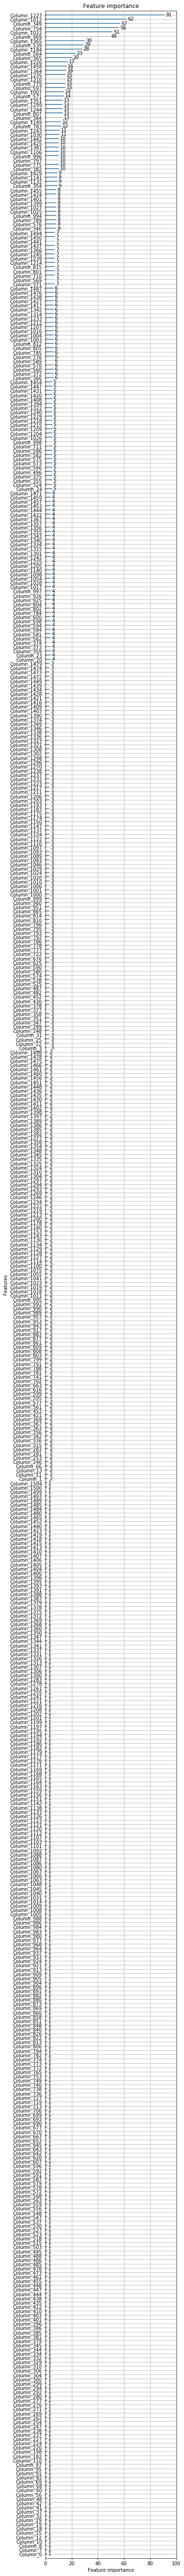

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_importance(bst, figsize=(5,100))